In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
DATASET_LOCATION = '/content/drive/MyDrive/ai-playground/ra-text-classification-spectrogram/spectrograms/bert-isot4000'
data_dir = pathlib.Path(DATASET_LOCATION)

In [4]:
TRAIN_FRACTION = 0.7
batch_size = 32 # default batch size of data
img_height = 224 # default height to which image is resized
img_width = 224 # default width to which image is resized
seed = 2022 # random seed for shuffling and transformations

In [5]:
ds_train = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 1 - TRAIN_FRACTION,
  subset = "training",
  seed = seed,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 3032 files belonging to 2 classes.
Using 2123 files for training.


In [6]:
ds_val = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 1 - TRAIN_FRACTION,
  subset = "validation",
  seed = seed,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 3032 files belonging to 2 classes.
Using 909 files for validation.


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = ds_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.Rescaling(1./255)


In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.059663963 1.0


In [10]:
class_names = ds_train.class_names
num_classes = len(class_names)
print(class_names)

['Fake', 'True']


In [11]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [13]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
67/67 [==============================] - 106s 1s/step - loss: 0.8763 - accuracy: 0.5125 - val_loss: 0.6887 - val_accuracy: 0.5259
Epoch 2/100
67/67 [==============================] - 3s 40ms/step - loss: 0.6813 - accuracy: 0.5662 - val_loss: 0.6396 - val_accuracy: 0.7525
Epoch 3/100
67/67 [==============================] - 3s 39ms/step - loss: 0.5307 - accuracy: 0.7635 - val_loss: 0.5156 - val_accuracy: 0.7360
Epoch 4/100
67/67 [==============================] - 3s 39ms/step - loss: 0.3140 - accuracy: 0.8752 - val_loss: 0.2358 - val_accuracy: 0.9120
Epoch 5/100
67/67 [==============================] - 3s 40ms/step - loss: 0.2362 - accuracy: 0.9053 - val_loss: 0.2418 - val_accuracy: 0.9032
Epoch 6/100
67/67 [==============================] - 3s 39ms/step - loss: 0.2202 - accuracy: 0.9157 - val_loss: 0.1933 - val_accuracy: 0.9274
Epoch 7/100
67/67 [==============================] - 3s 39ms/step - loss: 0.1924 - accuracy: 0.9204 - val_loss: 0.2268 - val_accuracy: 0.9208
Epoch 

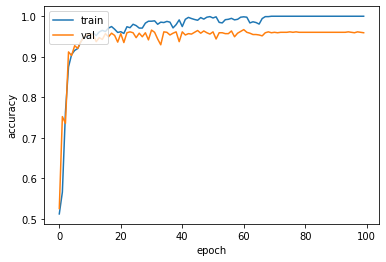

In [15]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()